# Tracer Identification

So we have a list of HITs and now we need to find out which ones are useful tracers and what they trace. 

First, we use ```radex-grid.py``` to run RADEX and calculate the line fluxes from the abundances. This will produce a table which we can load containing columns for the physical conditions and columns for the fluxes. After that, it's a simple matter of training random forests to predict the input variables.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler,QuantileTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import mean_absolute_percentage_error

from scipy.stats import spearmanr

plt.style.use("thesis")
def pretty_species_names(species):
    for i in range(1,4):
        species=species.replace(str(i),f"$_{i}$")
    species=species.replace("+","$^+$")
    species=species.replace("CL","Cl")
    return species

def ratio_from_name(name,df):
    line1=name.replace("RATIO(","")
    line1=line1.replace(")","")
    line2=line1.split("/")[1]
    line1=line1.split("/")[0]
    df[name]=df[line1]/df[line2]
    return df

phase="three_phase"

# Load Data

We've already calculated all the mutual information scores in ```generate_mutual_info_table.py``` but we need the original table here so that we can train some random forest models later. We also need to do the same pre-processing on it as we did for calculating the mutual info.

The key bit to preparing the data is the quantile transforming. RADEX occasionally sends ludicrously high values for certain lines and that's unrealistic. We assume they are large but not near infinite and then quantile transforming will simply compress them into the top percentiles of the distribution.

In [2]:
df=pd.read_hdf(f"../data/{phase}/radex-with-conditions.hdf",key="df").reset_index(drop=True)

physics=['initialTemp', 'radfield', 'Av', 'zeta', 'initialDens', 'rout']
df["initialDens"]=np.log10(df["initialDens"])
df["radfield"]=np.log10(df["radfield"])
df["zeta"]=np.log10(df["zeta"])

features=[x for x in df.columns if x not in physics]


rms=0.05
delta_v=5.0
n_channels=15.0
noise=rms*delta_v*np.sqrt(n_channels)
add_noise = lambda x: x+np.random.normal(0,noise)
df[features]=df[features].apply(add_noise)

#this actually boosts mutual information, probably by removing bad values (or pushing them to 0.99-1.0)
transformer=QuantileTransformer()
df[features]=transformer.fit_transform(df[features])
df=df+0.001

<AxesSubplot:ylabel='Count'>

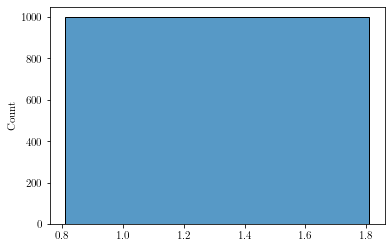

In [3]:
sns.histplot(add_noise(np.zeros(1000)))

In [8]:
feature_df=pd.read_hdf(f"../data/{phase}/feature_info_table.hdf",key="df")

#some extra columns
feature_df["Ratio"]=feature_df["Feature"].str.contains("RATIO")
feature_df["Molecule 1"]= feature_df["Feature"].map(lambda x: x.split("-")[0])
feature_df.loc[feature_df["Ratio"],"Molecule 1"]=feature_df.loc[feature_df["Ratio"],"Molecule 1"].map(lambda x: x.split("(")[1])
feature_df["Molecule 2"]="None"
feature_df.loc[feature_df["Ratio"],"Molecule 2"]=feature_df.loc[feature_df["Ratio"],"Feature"].map(lambda x: x.split("/")[1].split("-")[0])


#remove ratios of things with physics
idx=(feature_df["Feature"].str.contains(physics[0]))
for variable in physics[1:]:
    idx = idx | (feature_df["Feature"].str.contains(variable))
idx = (idx) & (feature_df["Feature"].str.contains("RATIO")) 
feature_df=feature_df.loc[~idx]

#and SIO
feature_df=feature_df.loc[~feature_df["Feature"].str.contains("SIO")]

#finally cut list down to 1% of most useful ratios
percentiles=feature_df.groupby("Target")["Info"].agg(lambda x: np.percentile(x,99))
filter_idx = feature_df["Ratio"]==False
for i,value in percentiles.iteritems():
    filter_idx = filter_idx | ((feature_df["Target"]==i)&(feature_df["Info"]>value))
feature_df=feature_df.loc[filter_idx]

feature_df["Molecules"]=feature_df[["Molecule 1","Molecule 2"]].apply(lambda x: "-".join(sorted(x)),axis=1).str.replace("-None","")
feature_df.to_csv(f"../data/{phase}/filter_importances.csv",index=False)

0                   CH-107.63
1                   CH-107.63
2                   CH-107.63
3                   CH-107.63
4                   CH-107.63
                 ...         
60818    CH2-593.12/SO-999.08
60819    CH2-605.51/SO-999.08
60820     CH2-68.36/SO-999.08
60821     CH2-69.04/SO-999.08
60822     CH2-70.66/SO-999.08
Name: Feature, Length: 60823, dtype: object

In [25]:
#for the website
feature_df=pd.read_csv(f"../data/{phase}/filter_importances.csv")
feature_df["Freq 1"]=feature_df["Feature"].map(lambda x: x.split("-")[1].split("/")[0])
feature_df["Freq 2"]=feature_df["Feature"].map(lambda x: x.split("-")[-1].replace(")",""))
feature_df["Feature"]=feature_df["Feature"].map(lambda x: x.split("(")[-1].replace(")",""))
feature_df.to_csv(f"../website/static/data/filter_importances.csv",index=False)
feature_df

,Feature,Target,Info,Ratio,Molecule 1,Molecule 2,Molecules,Freq 1,Freq 2
0,CH-107.63,initialTemp,0.607042,False,CH,None,CH,107.63,107.63
1,CH-107.63,radfield,0.064760,False,CH,None,CH,107.63,107.63
2,CH-107.63,Av,0.087303,False,CH,None,CH,107.63,107.63
3,CH-107.63,zeta,0.155700,False,CH,None,CH,107.63,107.63
4,CH-107.63,initialDens,0.281880,False,CH,None,CH,107.63,107.63
...,...,...,...,...,...,...,...,...,...
60818,CH2-593.12/SO-999.08,initialDens,0.741153,True,CH2,SO,CH2-SO,593.12,999.08
60819,CH2-605.51/SO-999.08,initialDens,0.742882,True,CH2,SO,CH2-SO,605.51,999.08
60820,CH2-68.36/SO-999.08,initialDens,0.725944,True,CH2,SO,CH2-SO,68.36,999.08
60821,CH2-69.04/SO-999.08,initialDens,0.725205,True,CH2,SO,CH2-SO,69.04,999.08


In [13]:
feature_df[feature_df["Target"]=="initialDens"].sort_values("Info")

,Feature,Target,Info,Ratio,Molecule 1,Molecule 2,Molecules,Freq 1,Freq 2
2986,HCS+-384.01,initialDens,0.000000,False,HCS+,None,HCS+,384.01,384.01
3040,HCS+-767.64,initialDens,0.000000,False,HCS+,None,HCS+,767.64,767.64
3022,HCS+-639.82,initialDens,0.000000,False,HCS+,None,HCS+,639.82,639.82
3052,HCS+-85.35,initialDens,0.000000,False,HCS+,None,HCS+,85.35,85.35
3064,HCS+-895.36,initialDens,0.000000,False,HCS+,None,HCS+,895.36,895.36
...,...,...,...,...,...,...,...,...,...
57689,RATIO(SO-408.64/SO-309.50),initialDens,0.901650,True,SO,SO,SO-SO,408.64,309.50
6022,RATIO(SO-66.03/CH2-593.12),initialDens,0.902543,True,SO,CH2,CH2-SO,66.03,593.12
58706,RATIO(SO-309.50/SO-408.64),initialDens,0.905412,True,SO,SO,SO-SO,309.50,408.64
50666,RATIO(SO-66.03/NO-750.96),initialDens,0.927877,True,SO,NO,NO-SO,66.03,750.96


# Most Important Features
This section is a working space where I find the most useful features. I use indexing to filter my list on different columns, most importantly by picking on target variable at a time. Then I just mess around until I have some useful things to write about in my results!

In [13]:
idx=feature_df["Target"]=="initialDens"
#idx=idx & (feature_df["Ratio"]==False)
#idx=idx & (feature_df["Molecule 1"].str.contains("H2CO"))
#idx=idx & (feature_df["Molecule 2"].str.contains("H2CO"))
#idx = idx & (feature_df["Feature"].str.contains("428.11"))
tracer_df=feature_df.loc[filter_idx & idx].sort_values("Info",ascending=False).reset_index(drop=True)
tracer_df.head(50)

,Feature,Target,Info,Ratio,Molecule 1,Molecule 2
0,RATIO(NO-750.96/SO-66.03),initialDens,0.930550,True,NO,SO
1,RATIO(SO-66.03/NO-750.96),initialDens,0.927877,True,SO,NO
2,RATIO(SO-309.50/SO-408.64),initialDens,0.905412,True,SO,SO
3,RATIO(SO-66.03/CH2-593.12),initialDens,0.902543,True,SO,CH2
4,RATIO(SO-408.64/SO-309.50),initialDens,0.901650,True,SO,SO
5,RATIO(SO-66.03/CH2-605.51),initialDens,0.901550,True,SO,CH2
6,RATIO(CH2-593.12/SO-66.03),initialDens,0.899588,True,CH2,SO
7,RATIO(CH2-605.51/SO-66.03),initialDens,0.898290,True,CH2,SO
8,RATIO(CH2-69.04/SO-66.03),initialDens,0.898176,True,CH2,SO
9,RATIO(SO-66.03/CH2-69.04),initialDens,0.898139,True,SO,CH2


In [79]:
tracer_df.groupby(["Molecule 1", "Molecule 2"])["Info"].max().reset_index().merge(
    tracer_df.groupby(["Molecule 1", "Molecule 2"])["Info"].min().reset_index(),
    on=["Molecule 1","Molecule 2"]).sort_values("Info_x",ascending=False).head(20)

,Molecule 1,Molecule 2,Info_x,Info_y
245,HCN,HNC,0.718433,0.000000
93,CO,H3O+,0.697903,0.075429
96,CO,HCO+,0.674423,0.031101
242,HCN,HCN,0.664986,0.000000
156,H2O,H3O+,0.662850,0.000000
261,HCO+,H3O+,0.660275,0.097142
154,H2O,H2O,0.656979,0.000000
172,H2S,CO,0.650779,0.000000
104,CO,SO,0.643247,0.000000
269,HCO+,NO,0.640140,0.000000


In [42]:
a=tracer_df["Feature"][0]
b=tracer_df["Feature"][1]
df=ratio_from_name(a,df)
df=ratio_from_name(b,df)

mutual_info_regression(df[a].values.reshape(-1,1),df[b])
spearmanr(df[a],df[b])

SpearmanrResult(correlation=0.9999999956874999, pvalue=0.0)

# Analysis bits and bobs

## Av vs FUV
Interesting that none of the top features are the same for these species, this little snippet below just checks the correlation coefficient between the two sets of informations to see if they're correlated at all.

In [ ]:
from scipy.stats import spearmanr
idx=feature_df["Variable"]=="radfield"
idx2=feature_df["Variable"]=="Av"

spearmanr(
    feature_df.loc[idx].sort_values("Feature")["Info"],
    feature_df.loc[idx2].sort_values("Feature")["Info"]

)

SpearmanrResult(correlation=0.1251241798634891, pvalue=0.00010317402236301194)

TypeError: unsupported operand type(s) for -: 'str' and 'str'

## Photodissociated?
We make a claim in the paper that the top most important molecules for determining Av are photodissociated a low Av. So I guess we need to test that.

In [ ]:
abunds=pd.read_hdf(f"../data/{phase}/final_abunds.hdf",key="df").reset_index(drop=True)
av_specs=["CO","HCL","SO","NO","H3O+"]
abunds=abunds[abunds["Species"].isin(av_specs)]
abunds["Abundance"]=np.log10(abunds["Abundance"])


In [ ]:
abunds["localUV"]=abunds["radfield"]*np.exp(-3.02*abunds["Av"])

In [ ]:
idx=abunds["Species"]=="H3O+"
spearmanr(
    abunds.loc[idx,"Abundance"],abunds.loc[idx,"Av"]

)

SpearmanrResult(correlation=0.3785998250184077, pvalue=0.0)

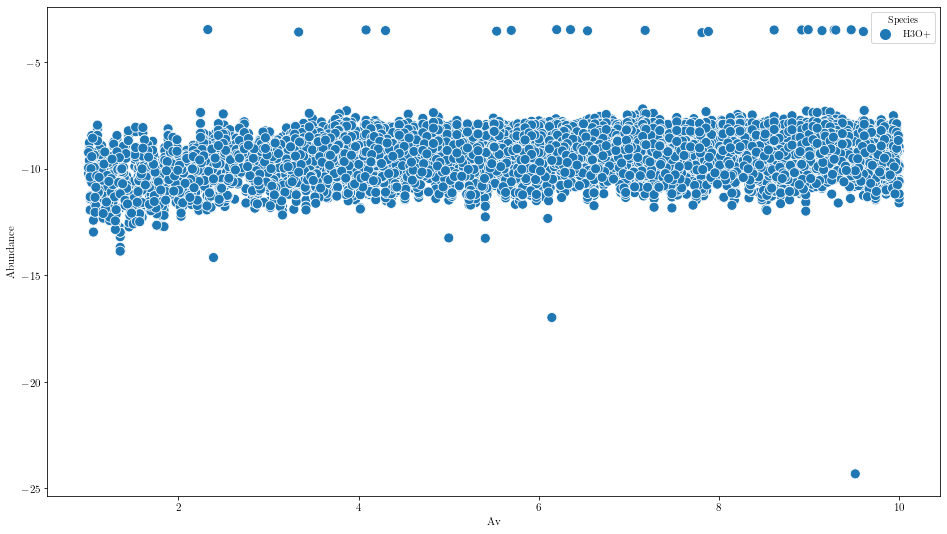

In [ ]:
fig,ax=plt.subplots(figsize=(16,9))
idx=abunds["Species"]=="H3O+"
sns.scatterplot(data=abunds.loc[idx],x="Av",y="Abundance",hue="Species",ax=ax)

## Most Useful
Many species appear multiple times in the top N lists of most useful species for a physical parameters. We might as well see if there's a subset of super HITs.


In [91]:
top_n=feature_df.groupby(["Target","Molecules"])["Info"].mean().reset_index()

In [92]:
top_n

,Target,Molecules,Info
0,Av,CH,0.080044
1,Av,CH-CO,0.575129
2,Av,CH-H2O,0.550390
3,Av,CH-NO,0.551946
4,Av,CH2,0.073248
...,...,...,...
304,zeta,NH3,0.110182
305,zeta,NO,0.155222
306,zeta,NO-NO,0.530693
307,zeta,NO-SO,0.508228


In [93]:
top_mols=pd.DataFrame()
n=5
for variable in physics:
    idx=top_n["Target"]==variable
    top_mols=top_mols.append(
        top_n.loc[idx].sort_values("Info",ascending=False)[["Target","Molecules"]].head(n)
    ,sort=False)
top_mols["Best"]="X"
top_mols=top_mols.pivot(index="Target",columns="Molecules",values="Best").T.fillna("")
top_mols=top_mols[["initialDens","initialTemp","zeta","radfield","Av"]]
top_mols.columns=["n$_{H2}$ / cm$^{-3}$","Temperature / K","$\zeta/\zeta_0$","F$_{UV}$ / Habing","A$_V$ / mag"]
top_mols=top_mols.reset_index()
top_mols["Count"]=top_mols.apply(lambda x: len("".join(x[1:])),axis=1)
top_mols["Molecules"]=top_mols["Molecules"].map(pretty_species_names)
top_mols=top_mols.sort_values("Count",ascending=False).drop("Count",axis=1)


In [94]:
top_mols

,Molecules,n$_{H2}$ / cm$^{-3}$,Temperature / K,$\zeta/\zeta_0$,F$_{UV}$ / Habing,A$_V$ / mag
6,CO-H$_2$S,,X,X,X,X
7,CO-H$_3$O$^+$,,,X,X,X
13,HCN-HCN,,,X,X,X
10,CO-NO,,X,X,X,
0,CH$_2$-CO,,X,,,
11,H$_2$CO-SO,X,,,,
17,NO-SO,X,,,,
16,N$_2$H$^+$-SO,X,,,,
15,HCS$^+$-SO,X,,,,
14,HCN-HNC,,,,X,


In [ ]:
top_mols.to_latex("../Paper/top_molecules.tex",index=False,escape=False)

Turns out they're really useful. The top ten are all miles more informative than any feature I have already included. So what do we do about that?

Well we could move to ratios but there's 77 million possible combinations of lines. More importantly, not every ratio is equally informative to its inverse. That means that we actually need to do all permutations of which there are 155 million. That ends up being 2500 CPU hours just to calculate mutual information between every ratio and the six target variables. It's not impossible, Harbinger could do it in 20 hours, but it's a lot of computation

# Fit a Forest
We originally fitted a random forest to each variable in turn and then produced a dataframe of all features and their Gini importance from the random fores fit to the variable. However, when we investigated whether the top 10 features from this importance were better predictors of a given variable than other rankings, we found the mutual information actually gave better individual variables. Since we want to independently rank variables by their use, we should use that rather than Gini importance in a large random forest model

In [44]:
feature_df["Molecules"]=feature_df[["Molecule 1","Molecule 2"]].apply(lambda x: "".join(sorted(x)),axis=1)

In [49]:
features=feature_df.loc[idx].sort_values("Info",ascending=False).groupby(["Molecule 1", "Molecule 2"])["Info"].max().reset_index()#.sort_values("Info",ascending=False)
features["Molecules"]=features[["Molecule 1","Molecule 2"]].apply(lambda x: "".join(sorted(x)),axis=1)
features=feature_df.merge(features,on=["Molecules","Info"]).sort_values("Info",ascending=False).reset_index(drop=True)
features=features.iloc[0:n_features]["Feature"].to_list()

In [50]:
features

['RATIO(SO-66.03/NO-750.96)',
 'RATIO(SO-66.03/CH3CN-165.36)',
 'RATIO(NO-824.74/SO-66.03)',
 'RATIO(SO-66.03/H2S-768.45)',
 'RATIO(SO-66.03/HCS+-341.35)',
 'RATIO(CN-113.17/SO-66.03)',
 'RATIO(SO-66.03/H2CO-72.41)',
 'RATIO(SO-66.03/N2H+-465.82)',
 'RATIO(SO-66.03/SO-190.01)',
 'RATIO(CH2-945.54/SO-174.93)']

In [55]:
fit_df=pd.DataFrame(columns=["Parameter","Mean Error","Number of Features"])
logged=["initialDens","radfield","zeta"]
prediction_df=pd.DataFrame()
labels=["Temperature / K","F$_{UV}$ / Habing","A$_V$ / mag","$\zeta/\zeta_0$","n$_{H2}$ / cm$^{-3}$","R / pc"]
predictors={}
predictor_features={}
ratio_run=True

for n_features in [1,5,10]:
    predictors[n_features]={}
    predictor_features[n_features]={}
    for i,variable in enumerate(physics):
        forest=RandomForestRegressor(100,criterion="mse")
        idx=feature_df["Target"]==variable
        idx=idx & (feature_df["Ratio"]==ratio_run)

        #Some features share mutual information so I remove multiple features from the same molecules
        features=feature_df.loc[idx].sort_values("Info",ascending=False).groupby(["Molecules"])["Info"].max().reset_index()#.sort_values("Info",ascending=False)
        features=feature_df.merge(features,on=["Molecules","Info"]).sort_values("Info",ascending=False).reset_index(drop=True)
        features=features.iloc[0:n_features]["Feature"].to_list()

        #ratios aren't in df so create them when needed as model input
        if ratio_run:
            for feature in features:
                df=ratio_from_name(feature,df)
            
        
        X_train,X_test,y_train,y_test=train_test_split(df[features],df[physics],random_state=42)

        y_true=y_test[variable]
        forest.fit(X_train[features],y_train[variable])
        y_pred=forest.predict(X_test[features])


        #mse=np.sqrt(np.mean((y_true-y_pred)**2.0))
        if variable in logged:
            mse=mean_absolute_percentage_error(10.0**y_true,10.0**y_pred)
        else:
            mse=mean_absolute_percentage_error(y_true,y_pred)
        fit_df.loc[len(fit_df)]=[labels[i],mse,n_features]
        predictors[n_features][variable]=forest
        predictor_features[n_features][variable]=features
        if n_features==5:

            temp_df=pd.DataFrame(columns=["True Value","Prediction"],data=np.asarray([y_true.values,y_pred]).T)
            temp_df["Parameter"]=variable
            prediction_df=prediction_df.append(temp_df)


In [56]:
fit_df=fit_df.pivot(index="Parameter",columns="Number of Features").reset_index()
fit_df=fit_df.sort_values(("Mean Error",10))

In [57]:
#ratios
fit_df

Parameter Mean Error                    
Number of Features                                1         5        10
4                        Temperature / K   0.754485  0.145545  0.067995
1                            A$_V$ / mag   0.307799  0.194873  0.169624
5                   n$_{H2}$ / cm$^{-3}$   1.716335  0.519909  0.192912
0                        $\zeta/\zeta_0$   5.940330  1.404277  0.904733
3                                 R / pc   2.841363  1.549639  1.006972
2                      F$_{UV}$ / Habing   9.795285  5.316520  4.591878

In [ ]:
#not ratios
fit_df

Parameter Mean Error                    
Number of Features                                1         5        10
4                        Temperature / K   0.694760  0.086794  0.070920
5                   n$_{H2}$ / cm$^{-3}$   1.725845  0.243299  0.127088
1                            A$_V$ / mag   0.468162  0.154536  0.138192
3                                 R / pc   4.685475  0.757079  0.404268
0                        $\zeta/\zeta_0$   4.243381  1.685736  1.183987
2                      F$_{UV}$ / Habing   8.907555  6.372826  5.163549

In [64]:
feature_df.groupby("Target")["Info"].max()

Target
Av             1.008893
initialDens    0.930550
initialTemp    1.280364
radfield       0.718433
rout           1.152287
zeta           0.749809
Name: Info, dtype: float64

In [58]:
predictor_features[5]["initialDens."]

['RATIO(NO-750.96/SO-66.03)',
 'RATIO(SO-309.50/SO-408.64)',
 'RATIO(SO-66.03/CH2-593.12)',
 'RATIO(SO-66.03/N2H+-279.51)',
 'RATIO(CH3CN-404.09/SO-66.03)']

In [59]:
predictor_features[10]["initialDens"]

['RATIO(NO-750.96/SO-66.03)',
 'RATIO(SO-309.50/SO-408.64)',
 'RATIO(SO-66.03/CH2-593.12)',
 'RATIO(SO-66.03/N2H+-279.51)',
 'RATIO(CH3CN-404.09/SO-66.03)',
 'RATIO(SO-66.03/H2S-708.47)',
 'RATIO(CH-113.66/SO-66.03)',
 'RATIO(HCS+-85.35/SO-66.03)',
 'RATIO(SO-66.03/H2CO-587.45)',
 'RATIO(NO-618.79/NO-852.24)']

In [60]:
fit_df.to_latex("../Paper/prediciton_rms.tex",index=False,formatters=[None,lambda x: f"{x:.1%}",lambda x: f"{x:.1%}",lambda x: f"{x:.1%}"],escape=False)

<ipython-input-74-cc47f270f34f>:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_yticklabels([f"10$^{{{x:.0f}}}$" for x in axes[i].get_yticks()])
<ipython-input-74-cc47f270f34f>:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_yticklabels([f"10$^{{{x:.0f}}}$" for x in axes[i].get_yticks()])
<ipython-input-74-cc47f270f34f>:18: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "type" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.savefig("../Paper/predictions.pdf",type="PDF")


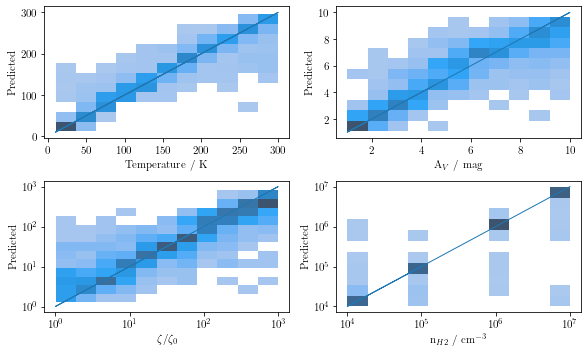

In [74]:
fig,axes=plt.subplots(2,2,figsize=(8.27,5),tight_layout=True)
axes=axes.flatten()
plot_labels=["Temperature / K","A$_V$ / mag","$\zeta/\zeta_0$","n$_{H2}$ / cm$^{-3}$"]

for i,variable in enumerate([x for x in physics if x not in ["rout","radfield"]]):
    idx=prediction_df["Parameter"]==variable
    y_true=prediction_df.loc[idx,"True Value"].values
    y_pred=prediction_df.loc[idx,"Prediction"].values
    sns.histplot(x=y_true,y=y_pred,ax=axes[i])
    axes[i].set(xlabel=plot_labels[i],ylabel="Predicted")
    axes[i].plot(y_true,y_true)
    if variable in logged:
        min_x=int(y_true.min())
        max_x=int(np.round(y_true.max()))
        axes[i].set_xticks(np.arange(min_x,max_x+1,1))
        axes[i].set_xticklabels([f"10$^{{{x:.0f}}}$" for x in axes[i].get_xticks()])
        axes[i].set_yticklabels([f"10$^{{{x:.0f}}}$" for x in axes[i].get_yticks()])
fig.savefig("../Paper/predictions.pdf",type="PDF")

In [73]:
axes[i].get_xticks()

array([4, 5, 6, 7])

In [71]:
y_true.max()
y_true.min()

4.001